<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/CIFAR10_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My first CNN project

## Imports and GPU

In [1]:
# calculations
import numpy as np

# model
import torch
import torch.nn as nn
import torch.nn.functional as F

# dataset and transformations
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-a680a4fd67af>:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Datasets and Transformation

In [3]:
# transformations for training
transform_train = T.Compose([ T.ToTensor(),
                              T.Normalize([.5,.5,.5],[.5,.5,.5]),
                              T.RandomHorizontalFlip(),
                            ])

# transformations for dev and test
transform_test = T.Compose([ T.ToTensor(),
                              T.Normalize([.5,.5,.5],[.5,.5,.5]),
                            ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform_train)
devtest  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# split the devtest into three separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:5000]) # Subset for devset
testset = Subset(devtest,randidx[5000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

100%|██████████| 170498071/170498071 [00:13<00:00, 12400284.58it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# and the range of pixel intensity values
print('\nData value range:')
print( (np.min(trainset.data),np.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
50000
5000
5000

Data value range:
(0, 255)

Data categories:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Creating the Model

In [5]:
# create a class for the model
def makeTheNet():

  class cifarNet(nn.Module):
    def __init__(self):
      super().__init__()


      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(3, 64, 3, padding=2)
      self.bnorm1 = nn.BatchNorm2d(64)
      # output size: (32+2*2-3)/1 + 1 = 34/2 = 17

      # second convolution layer
      self.conv2  = nn.Conv2d(64, 128, 3, padding=2)
      self.bnorm2 = nn.BatchNorm2d(128)
      # output size: (17+2*2-3)/1 + 1 = 19/2 = 9

      # second convolution layer
      self.conv3  = nn.Conv2d(128, 256, 3, padding=1)
      self.bnorm3 = nn.BatchNorm2d(256)
      # output size: (9+2*1-3)/1 + 1 = 9/2 = 4

      # forth convolution layer
      self.conv4  = nn.Conv2d(256, 512, 3, padding=1)
      self.bnorm4 = nn.BatchNorm2d(512)
      # output size: (4+2*1-3)/1 + 1 = 2/2 = 2


      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(2*2*512, 1024)

      self.fc2 = nn.Linear(1024, 512)

      self.fc3 = nn.Linear(512, 10)


    def forward(self,x):

      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x), 2)
      x = F.leaky_relu(self.bnorm1(x))

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x), 2)
      x = F.leaky_relu(self.bnorm2(x))

      # third block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv3(x), 2)
      x = F.leaky_relu(self.bnorm3(x))

      # forth block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv4(x), 2)
      x = F.leaky_relu(self.bnorm4(x))

      # reshape for linear layer
      nUnits = x.shape.numel() / x.shape[0]
      x = x.view(-1, int(nUnits))


      # linear layers with batch normalization
      x = F.leaky_relu(self.fc1(x))                  # 1st layer
      x = F.dropout(x,p=.5,training=self.training)   # Dropout
      x = F.leaky_relu(self.fc2(x))                  # 2nd layer
      x = F.dropout(x,p=.5,training=self.training)   # Dropout
      x = self.fc3(x)                                # output


      return x

  # create the model instance
  net = cifarNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.AdamW(net.parameters(),lr=.001)

  return net, lossfun, optimizer

In [6]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3781, grad_fn=<NllLossBackward0>)


## Training

In [12]:
def function2trainTheModel():

  # number of epochs
  numepochs = 12

  # create a new model
  net, lossfun, optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc   = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):
    print(f'{epochi}/{numepochs}')

    # loop over training data batches
    net.train()
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracy rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    ### dev performance
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from dev dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)

    # get loss and accuracy rate from the dev batch
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss, devLoss, trainAcc, devAcc, net

In [ ]:
trainLoss, devLoss, trainAcc, devAcc, net = function2trainTheModel()

0/12
1/12


## Plotting losses and accuracy for train and dev

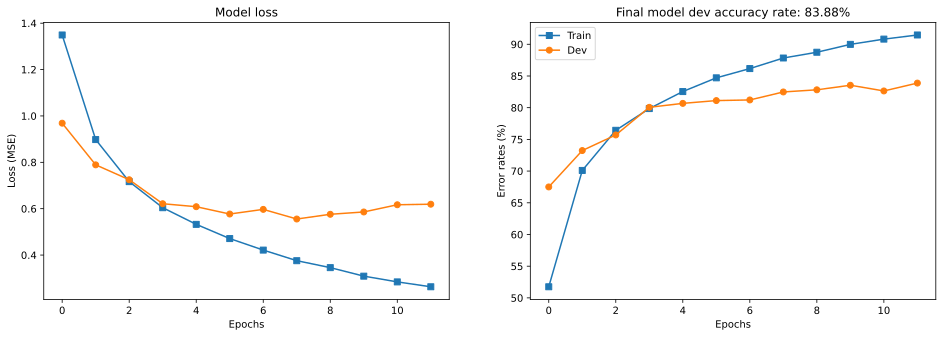

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev accuracy rate: {devAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# FINAL TEST FOR ACCURACY

In [11]:
### FINAL TEST
net.eval()
X, y = next(iter(test_loader)) # extract X,y from test dataloader

# push data to GPU
X = X.to(device)
y = y.to(device)

with torch.no_grad(): # deactivates autograd
    yHat = net(X)
    loss = lossfun(yHat,y)

# get loss and accuracy rate from the test batch
print(f'LOSS : {loss.item()}')
print(f'ACCURACY: {100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()}')

LOSS : 0.5651001930236816
ACCURACY: 84.23999547958374
